# Summarizing Images

Images are _high dimensional_ objects: our XMM image contains `648*648 = ` datapoints (the pixel values).

Visualizing the data is an extremely important first step: the next is _summarizing_, which can be thought of as _dimensionality reduction_.

Let's dust off some standard statistics and put them to good use in summarizing this X-ray image.



In [49]:
from __future__ import print_function
import astropy.io.fits as pyfits
import numpy as np
import astropy.visualization as viz
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) 

In [50]:
targdir = 'a1835_xmm/'
imagefile = targdir+'P0098010101M2U009IMAGE_3000.FTZ'
expmapfile = targdir+'P0098010101M2U009EXPMAP3000.FTZ'
bkgmapfile = targdir+'P0098010101M2X000BKGMAP3000.FTZ'

!du -sch $targdir/*

4.0K	a1835_xmm//M2ptsrc.txt
464K	a1835_xmm//P0098010101M2U009EXPMAP3000.FTZ
 48K	a1835_xmm//P0098010101M2U009IMAGE_3000.FTZ
472K	a1835_xmm//P0098010101M2X000BKGMAP3000.FTZ
988K	total


## How Many Photons Came From the Cluster?

Let's estimate the total counts due to the cluster.

That means we need to somehow ignore

* all the other objects in the field

* the diffuse X-ray "background"

Let's start by _masking_ various regions of the image to separate cluster from background.

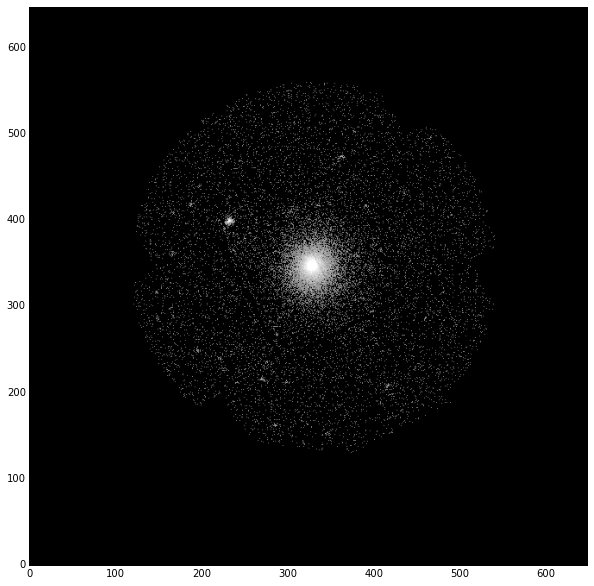

In [51]:
imfits = pyfits.open(imagefile)
im = imfits[0].data
plt.imshow(viz.scale_image(im, scale='log', max_cut=40), cmap='gray', origin='lower');

### Estimating the background

Now let's look at the outer parts of the image, far from the cluster, and estimate the background level there.

In [52]:
# First make some coordinate arrays, including polar r from the cluster center:
ny, nx = im.shape
centroid = np.unravel_index(im.argmax(), im.shape)
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
dx, dy = np.meshgrid(x,y)
dx = dx - centroid[1]
dy = dy - centroid[0]
r = np.sqrt(dx*dx + dy*dy)

In [53]:
# Now select an outer annulus, for the background,
# and an inner circle, for the cluster: 
background = (r >= 100.0) & (r <= 150.0)
signal = (r < 100.0)

First, let's visualize the background region by masking out everything else.

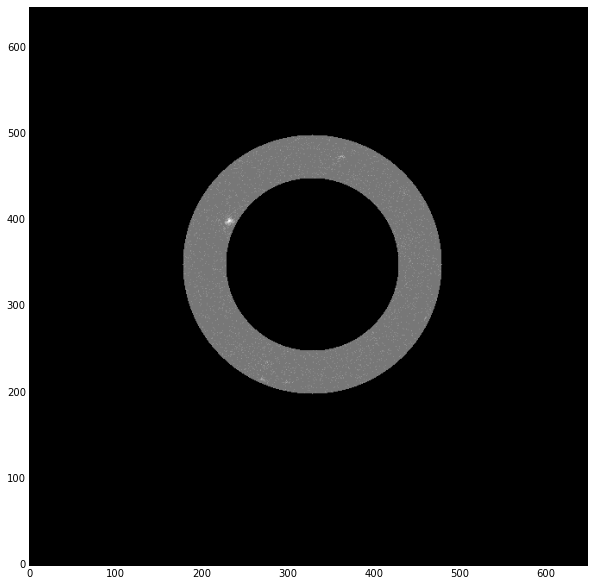

In [54]:
maskedimage = im.copy()
maskedimage[np.logical_not(background)] = -1
plt.imshow(viz.scale_image(maskedimage, scale='log', max_cut=40), cmap='gray', origin='lower')

Now let's look at the _mean_ and _median_ of the pixels in the background annulus that have non-negative values.

In [55]:
meanbackground = np.mean(im[background])
medianbackground = np.median(im[background])

print("Mean background counts per pixel = ",meanbackground)
print("Median background counts per pixel = ",medianbackground)

Mean background counts per pixel =  0.0913094389573
Median background counts per pixel =  0.0


### Q:  Why do you think there's a difference? 
Talk to your neighbor for a minute, and be ready to suggest an answer.

To understand the difference in these two estimates, lets look at a _pixel histogram_ for this annulus.

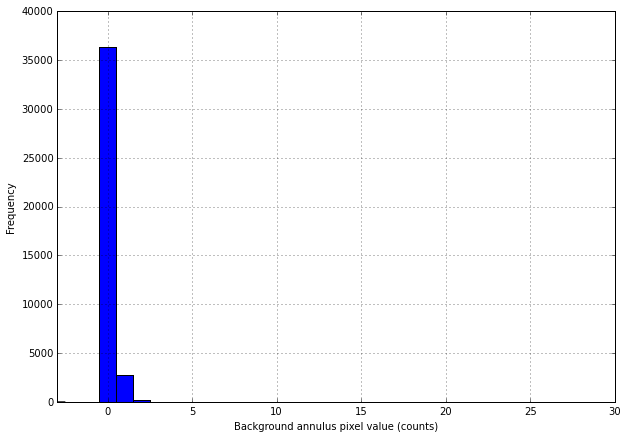

In [56]:
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(im[background], bins=np.linspace(-3.5,29.5,34))
# plt.yscale('log', nonposy='clip')
plt.xlabel('Background annulus pixel value (counts)')
plt.ylabel('Frequency')
plt.axis([-3.0, 30.0, 0, 40000])
plt.grid(True)
plt.show()

In [57]:
stdevbackground = np.std(im[background])
print("Standard deviation: ",stdevbackground)

Standard deviation:  0.659138624851


### Exercise:

_"The background level in this image is approximately $0.09 \pm 0.66$ counts"_

What's wrong with this statement?

Talk to your neighbor for a few minutes, and see if you can come up with a better version.

### Estimating the Cluster  Counts

Now let's summarize the circular region centered on the cluster, by making another masked image.

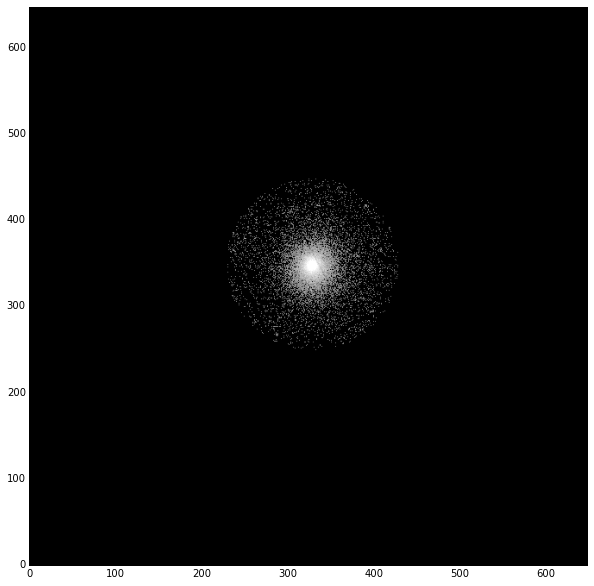

In [58]:
maskedimage = im.copy()
maskedimage[np.logical_not(signal)] = 0
plt.imshow(viz.scale_image(maskedimage, scale='log', max_cut=40), cmap='gray', origin='lower')

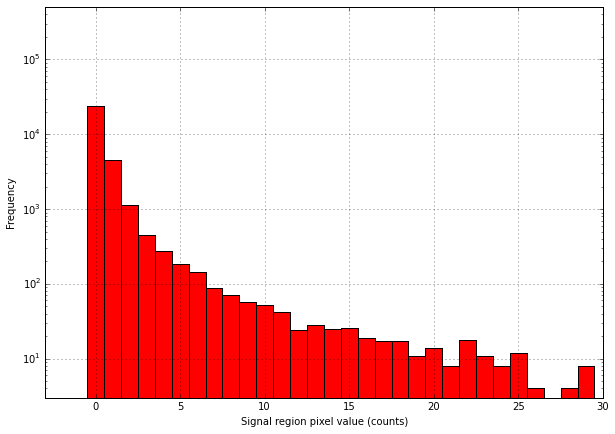

In [59]:
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(im[signal], bins=np.linspace(-3.5,29.5,34), color='red')
plt.yscale('log', nonposy='clip')
plt.xlabel('Signal region pixel value (counts)')
plt.ylabel('Frequency')
plt.axis([-3.0, 30.0, 0, 500000])
plt.grid(True)
plt.show()

Now we can make our estimates: 

In [61]:
# Total counts in signal region:
Ntotal = np.sum(im[signal])

# Background counts: the mean counts per pixel in the annulus, 
# multiplied by the number of pixels in the signal region:
Nbackground = np.count_nonzero(signal)*meanbackground  # Is this a good choice?

# Difference is the cluster counts:
Ncluster = Ntotal - Nbackground

print("Counts in signal region: ",Ntotal)
print("Approximate counts due to background: ",Nbackground)
print("Approximate counts due to cluster: ",Ncluster)

Counts in signal region:  28195
Approximate counts due to background:  2866.84245494
Approximate counts due to cluster:  25328.1575451


## Lessons

Summary statistics are how we:

* _reduce the dimensionality_ of datasets to a level where we can make sense of what is going on

* make _rough estimates_ of important quantities we are interested in

But:

* their _uncertainty_ is non-trivial to estimate, and at least requires more information